# Validation: Delay mean sensitivity

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* Tests the effect of different delay probability distribution means  

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy
import copy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
import sensitivityplotlib as spl

sns.set_style("ticks")
%matplotlib inline

In [104]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


In [105]:
def gamma_mu_cov_to_shape_scale(mu, cov):
    shape = 1/(cov**2)
    scale = mu * (cov**2)
    return shape, scale

def calc_shifted_delay_mean_death(mean_shift):
    nRVs= int(9e7)
    shp1, scl1 = gamma_mu_cov_to_shape_scale(5.1 + mean_shift, 0.86)
    shp2, scl2 = gamma_mu_cov_to_shape_scale(18.8 + mean_shift, 0.45)
    samples = np.random.gamma(shape=shp1, scale=scl1, size=nRVs) + np.random.gamma(shape=shp2, scale=scl2, size=nRVs)
    bins = np.arange(-1, 64.0)
    bins[2:] += 0.5
    #print(f"Binned As {bins}")
    n, _, _ = plt.hist(samples, bins);
    delay_prob = n / np.sum(n)
    #print(f"Expectation: {np.sum([(i) * delay_prob[i] for i in range(64)])}")
    #print(f"True Mean: {np.mean(samples)}")
    #print(f"Delay Prob: {delay_prob}")
    return delay_prob

def calc_shifted_delay_mean_conf(mean_shift):
    m = 5.25 + mean_shift
    r = 1.57
    p = m/(m+r)
    
    nRVs= int(9e7)
    shp1, scl1 = gamma_mu_cov_to_shape_scale(5.1 + mean_shift, 0.86)
    samples = np.random.gamma(shape=shp1, scale=scl1, size=nRVs) + np.random.negative_binomial(r, (1-p), size=nRVs)
    bins = np.arange(-1, 32.0)
    bins[2:] += 0.5
    #print(f"Binned As {bins}")
    n, _, _ = plt.hist(samples, bins);
    delay_prob = n / np.sum(n)
    #print(f"Expectation: {np.sum([(i) * delay_prob[i] for i in range(64)])}")
    #print(f"True Mean: {np.mean(samples)}")
    #print(f"Delay Prob: {delay_prob}")
    return delay_prob

In [106]:
def vary_delay_mean(model, mean_shift, model_type):
    '''to use for deaths model or active cases model'''
    default_mean = np.trapz(model.DelayProb*(np.arange(len(model.DelayProb))))
    print('Default mean: '+ str(default_mean))
    if (mean_shift+default_mean)==default_mean:
        pass
    else:
        if model_type == 'active':
            delay_prob = calc_shifted_delay_mean_conf(mean_shift)
        if model_type == 'death': 
            delay_prob = calc_shifted_delay_mean_death(mean_shift)
        model.DelayProb = delay_prob
    return model
    
def vary_delay_mean_confirmed(model, mean_shift):
    '''to use for combined model'''
    default_mean = np.trapz(model.DelayProbCases[0]*(np.arange(len(model.DelayProbCases[0]))))
    print('Default mean conf: '+ str(default_mean))
    if (mean_shift+default_mean)==default_mean:
        pass
    else:
        delay_prob = calc_shifted_delay_mean_conf(mean_shift)
        model.DelayProbCases = delay_prob
    return model

def vary_delay_mean_death(model, mean_shift):
    '''to use for combined model'''
    default_mean = np.trapz(model.DelayProbDeaths[0]*(np.arange(len(model.DelayProbDeaths[0]))))
    print('Default mean death: '+ str(default_mean))
    if (mean_shift+default_mean)==default_mean:
        pass
    else:
        delay_prob = calc_shifted_delay_mean_death(mean_shift)
        model.DelayProbDeaths = delay_prob
    return model

## build and run model
skip this if you already have traces 

In [107]:
mean_shift = [-2, -1, 1, 2]
model_types = ['combined', 'active', 'death']
samples = 1000
chains = 8
cores = 8

Delay Mean Shift: -2
Model: combined
Default mean conf: 10.102311679999998
Default mean death: 23.84020679695945
Delay Mean Shift: -1
Model: combined
Default mean conf: 10.102311679999998
Default mean death: 23.84020679695945
Delay Mean Shift: 1
Model: combined
Default mean conf: 10.102311679999998
Default mean death: 23.84020679695945
Delay Mean Shift: 2
Model: combined
Default mean conf: 10.102311679999998
Default mean death: 23.84020679695945
Delay Mean Shift: -2
Model: active
Default mean: 10.102311679999998
Delay Mean Shift: -1
Model: active
Default mean: 10.102311679999998
Delay Mean Shift: 1
Model: active
Default mean: 10.102311679999998
Delay Mean Shift: 2
Model: active
Default mean: 10.102311679999998
Delay Mean Shift: -2
Model: death
Default mean: 23.84020679695945
Delay Mean Shift: -1
Model: death
Default mean: 23.84020679695945
Delay Mean Shift: 1
Model: death
Default mean: 23.84020679695945
Delay Mean Shift: 2
Model: death
Default mean: 23.84020679695945


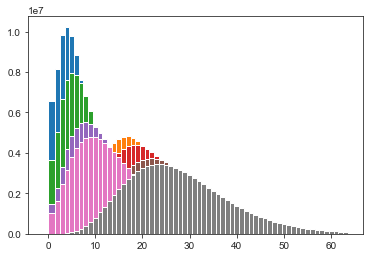

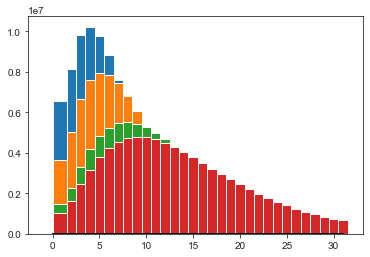

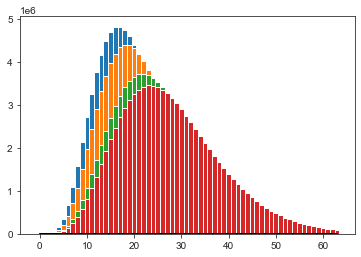

In [108]:
delay_probs_conf_combined = []
delay_probs_death_combined = []
delay_probs_death = []
delay_probs_active = []

for model_type in model_types:
    plt.figure()
    if model_type=='combined':
    # for combined model vary confirmed and deaths delay
        for i in range(len(mean_shift)):
            print('Delay Mean Shift: ' + str(mean_shift[i]))
            print('Model: ' + str(model_type))
            with cm_effect.models.CMCombined_Final(data) as model:
                model = vary_delay_mean_confirmed(model, mean_shift[i])
                delay_probs_conf_combined.append(model.DelayProbCases) 
                model.build_model()
            #model.run(samples, chains=2, cores=2)
            #filename = 'out_final/delay_mean_confirmed_combined_' + str(i) + '.txt'
            #cm_trace = model.trace["CMReduction"]
            #np.savetxt(filename, cm_trace)

            with cm_effect.models.CMCombined_Final(data) as model:
                model = vary_delay_mean_death(model, mean_shift[i])
                delay_probs_death_combined.append(model.DelayProbDeaths) 
                model.build_model()
            #model.run(samples, chains=chains, cores=cores)
            #filename = 'out_final/delay_mean_death_combined_' + str(i) + '.txt'
            #cm_trace = model.trace["CMReduction"]
            #np.savetxt(filename, cm_trace)
    else:
    # for other models there is only one delay mean
        for i in range(len(mean_shift)):
            print('Delay Mean Shift: ' + str(mean_shift[i]))
            print('Model: ' + str(model_type))
            if model_type=='active':
                with cm_effect.models.CMActive_Final(data) as model:
                    plt.plot(model.DelayProb, color='k', label='default')
                    model = vary_delay_mean(model, mean_shift[i], model_type)
                    delay_probs_active.append(model.DelayProb) 
                    model.build_model()
            if model_type=='death':
                with cm_effect.models.CMDeath_Final(data) as model:
                    plt.plot(model.DelayProb, color='k', label='default')
                    model = vary_delay_mean(model, mean_shift[i], model_type)
                    delay_probs_death.append(model.DelayProb) 
                    model.build_model()
            #model.run(samples, chains=chains, cores=cores)
            #filename = 'out_final/delay_mean_' + model_type + '_' + str(i) + '.txt'
            #cm_trace = model.trace["CMReduction"]
            #np.savetxt(filename, cm_trace)

combined
6.353130494429552
8.29592579639805
11.691593752850277
13.034087795167046
active
6.355590136536601
8.29668089207274
11.691276997691741
13.033319449162319
death
19.893153759561006
21.87753069073071
25.7561792469188
27.602753870518356


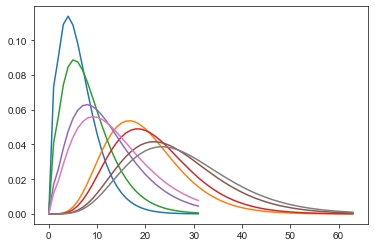

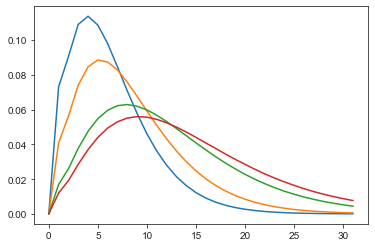

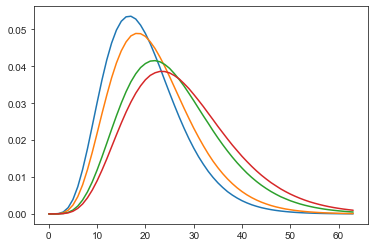

In [109]:
delay_means_conf_combined = []
delay_means_death_combined = [] 
delay_means_active = []
delay_means_death = []
for model_type in model_types:
    plt.figure()
    print(model_type)
    for i in range(len(mean_shift)):
        if model_type == 'combined':
            shifted_mean_conf = np.trapz(delay_probs_conf_combined[i]*(np.arange(len(delay_probs_conf_combined[i]))))
            delay_means_conf_combined.append(shifted_mean_conf)
            shifted_mean_death = np.trapz(delay_probs_death_combined[i]*(np.arange(len(delay_probs_death_combined[i]))))
            delay_means_death_combined.append(shifted_mean_death)
            print(shifted_mean_conf)
            plt.plot(delay_probs_conf_combined[i], label = shifted_mean_conf)
            plt.plot(delay_probs_death_combined[i], label = shifted_mean_death)
        if model_type == 'active':
            shifted_mean = np.trapz(delay_probs_active[i]*(np.arange(len(delay_probs_active[i]))))
            print(shifted_mean)
            delay_means_conf_combined.append(shifted_mean)
            plt.plot(delay_probs_active[i], label=shifted_mean)
        if model_type == 'death':
            shifted_mean = np.trapz(delay_probs_death[i]*(np.arange(len(delay_probs_death[i]))))
            print(shifted_mean)
            delay_means_conf_combined.append(shifted_mean)
            plt.plot(delay_probs_death[i], label=shifted_mean)

### Plot traces 

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/arviz/plots/backends/mat

<Figure size 432x288 with 0 Axes>

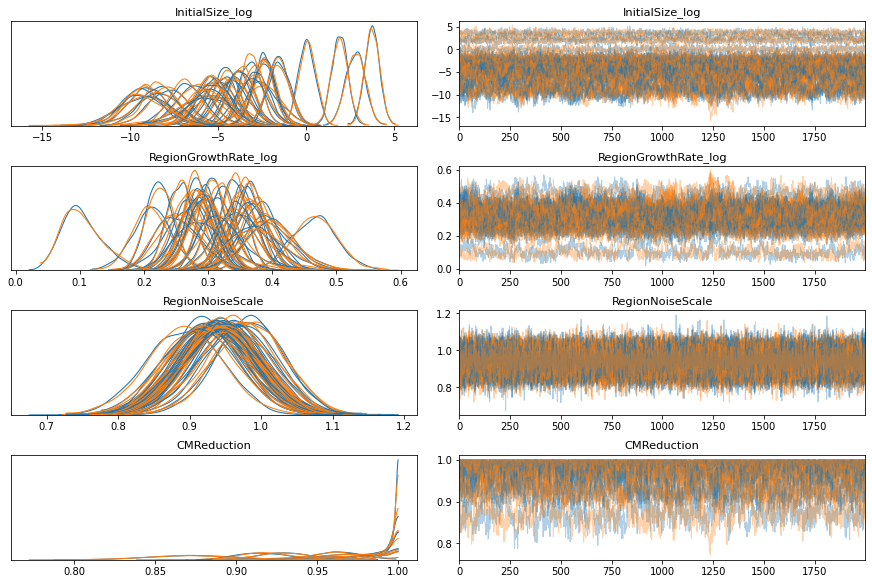

<Figure size 432x288 with 0 Axes>

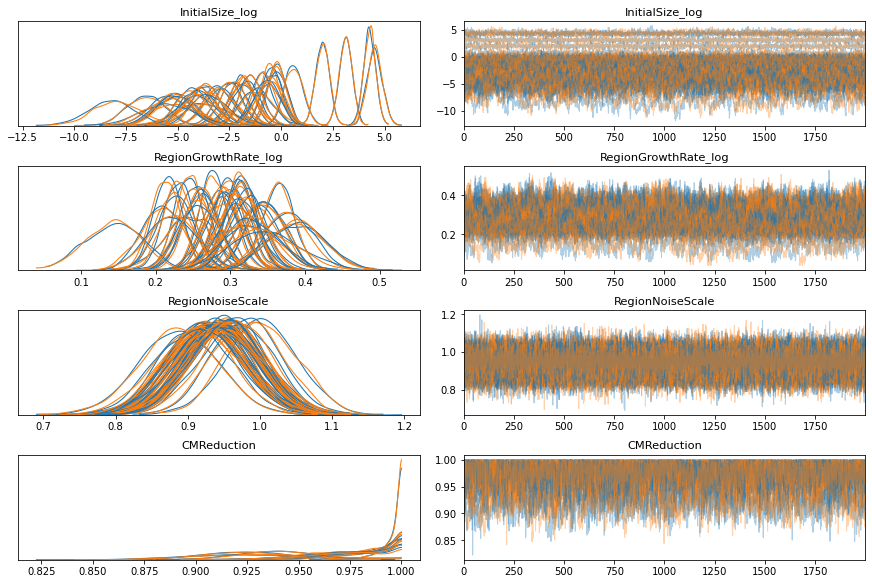

<Figure size 432x288 with 0 Axes>

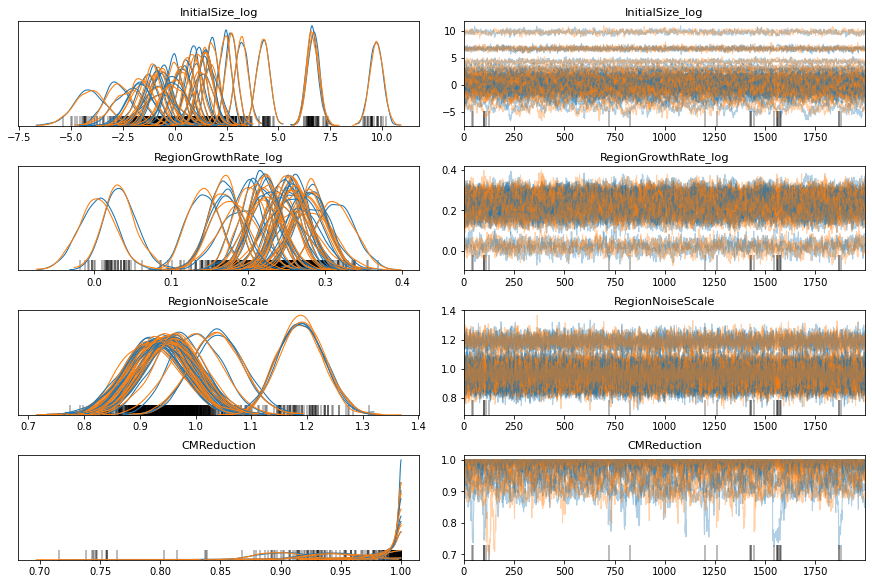

In [105]:
for model in models:
    plt.figure()
    model.plot_traces()

### Plot countermeasure effectiveness sensitivity for each model

In [100]:
# choose plot params
index_default=2
legend_labels = copy.deepcopy(mean_shift)
legend_labels.insert(2,'0 (default)')
cm_labels = data.CMs
y_offset = 0.1


#### for active model

<Figure size 432x288 with 0 Axes>

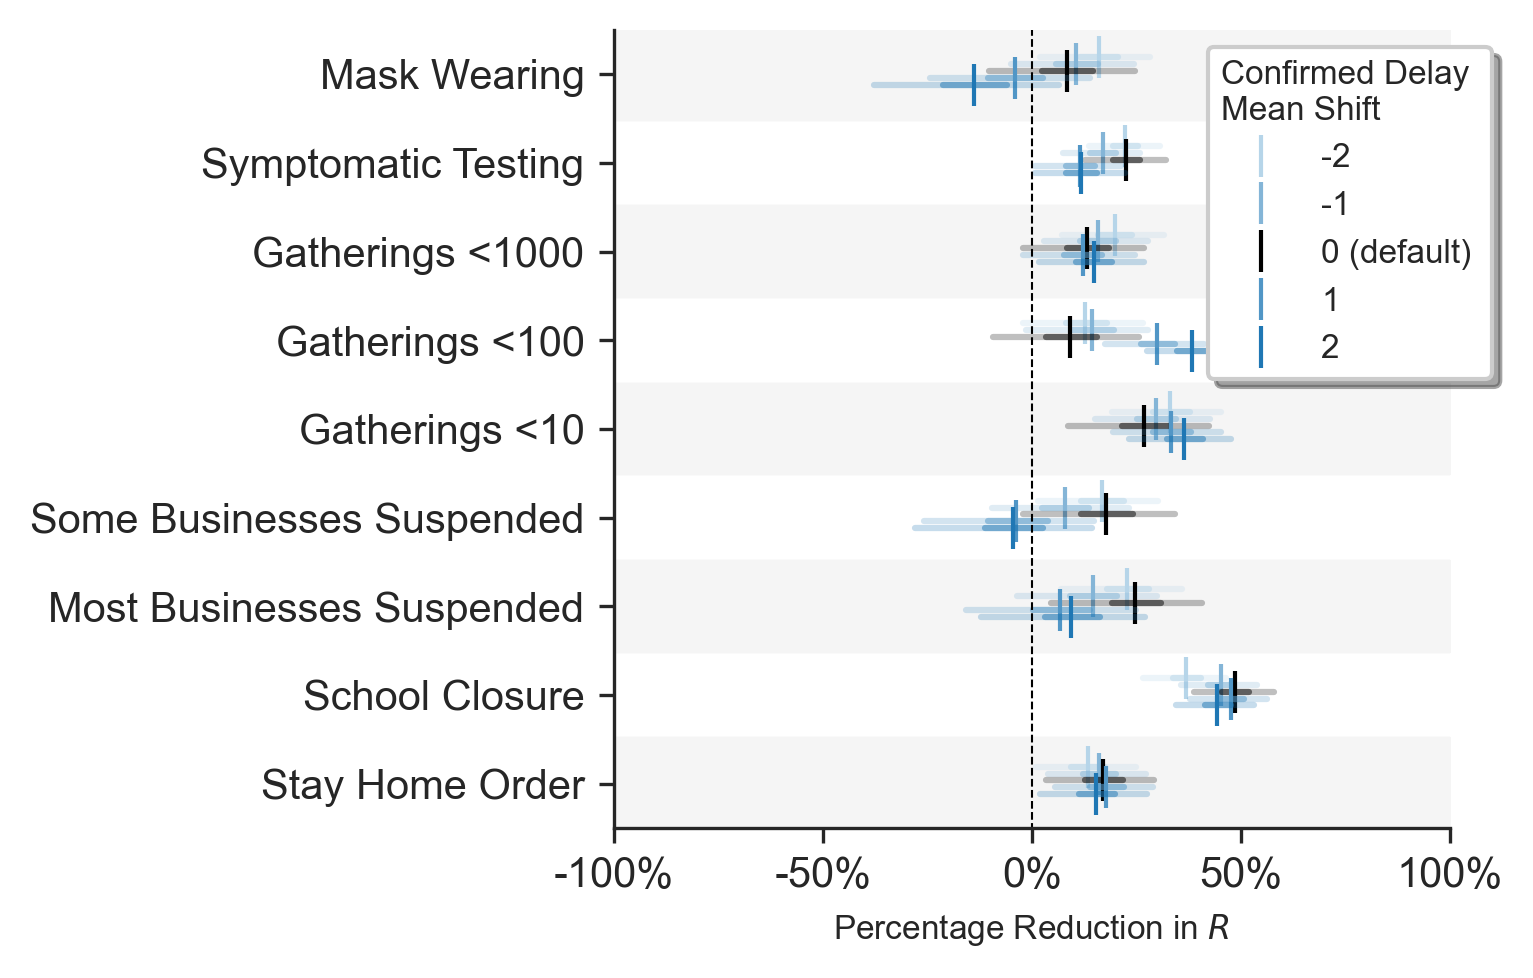

In [101]:
colors= sns.light_palette("tab:blue",n_colors=5)#sns.color_palette('Purples', 6)
colors.reverse()
colors.insert(index_default,[0,0,0])
colors = colors[0:5]
colors.reverse()

plt.figure()
filenames = [f'out_final/delay_mean_active_{i}.txt' for i in range(len(mean_shift))]
filenames.insert(index_default,'out_final/default_active.txt')
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               colors=colors, 
                               y_offset=y_offset,
                               legend_title='Confirmed Delay \nMean Shift',
                               bbox_to_anchor=(1.07,1),
                               figsize=(5.2,3.3))
plt.savefig('out_final/delay_mean_sensitivity_active.pdf')

#### for deaths model

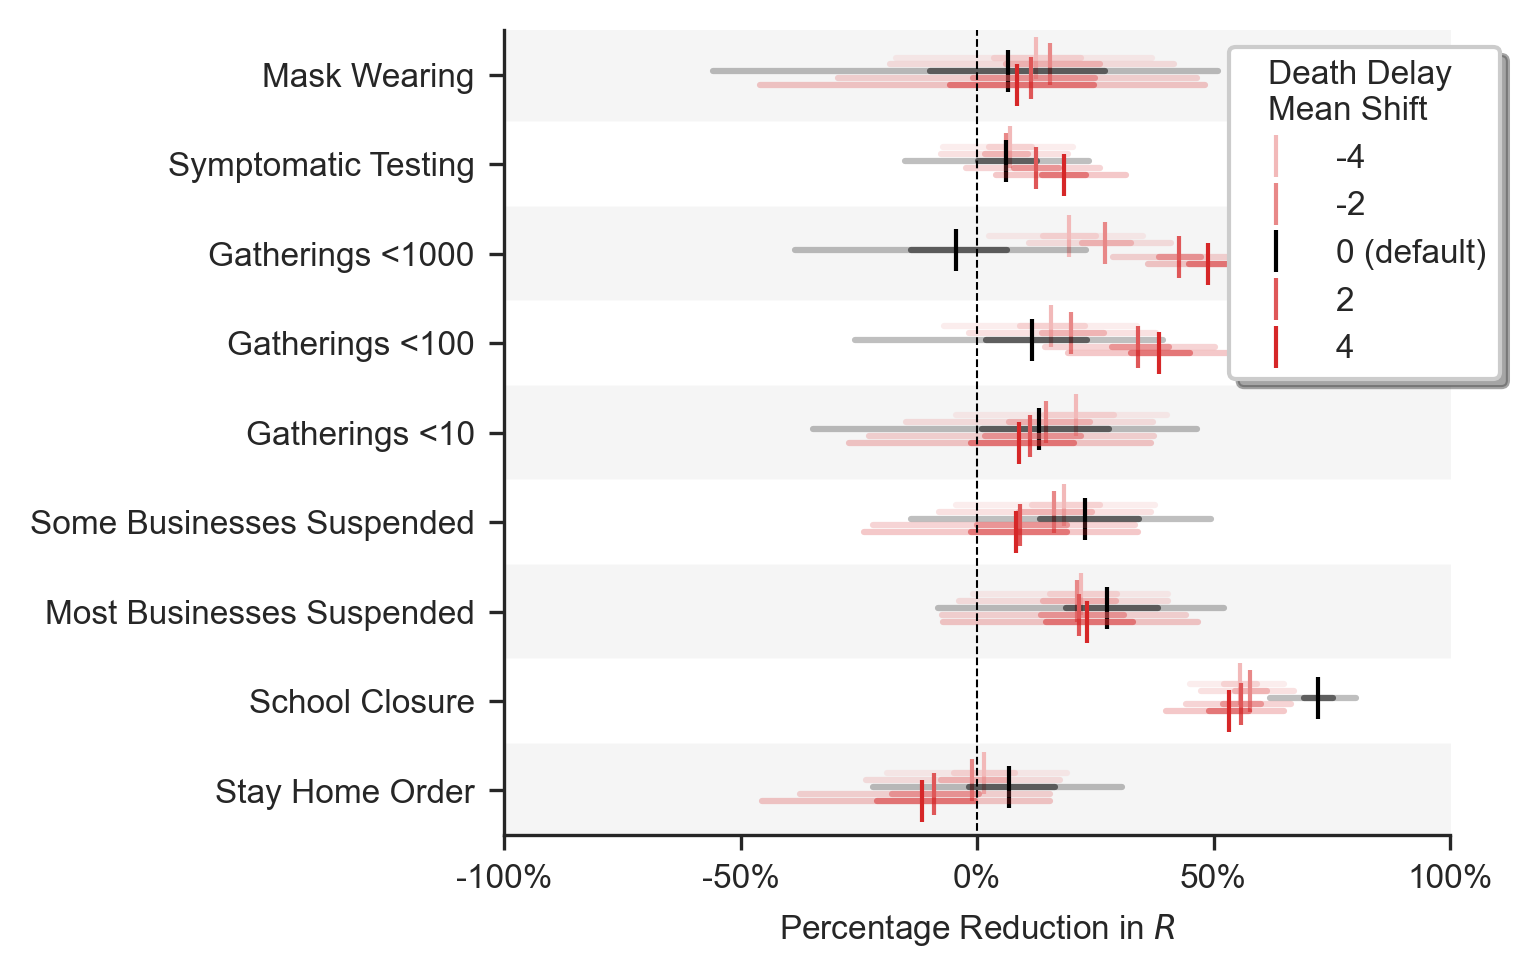

In [37]:
colors= sns.light_palette("tab:red",n_colors=5)#sns.color_palette('Purples', 6)
colors.reverse()
colors.insert(index_default,[0,0,0])
colors = colors[0:5]
colors.reverse()

filenames = [f'out_final/delay_mean_death_{i}.txt' for i in range(len(mean_shift))]
filenames.insert(index_default,'out_final/default_death.txt')
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               colors=colors,
                               y_offset=y_offset,
                               legend_title='Death Delay \nMean Shift',
                               bbox_to_anchor=(1.07,1),
                               figsize=(5.2,3.3))
plt.savefig('out_final/delay_mean_sensitivity_death.pdf')

#### for combined model

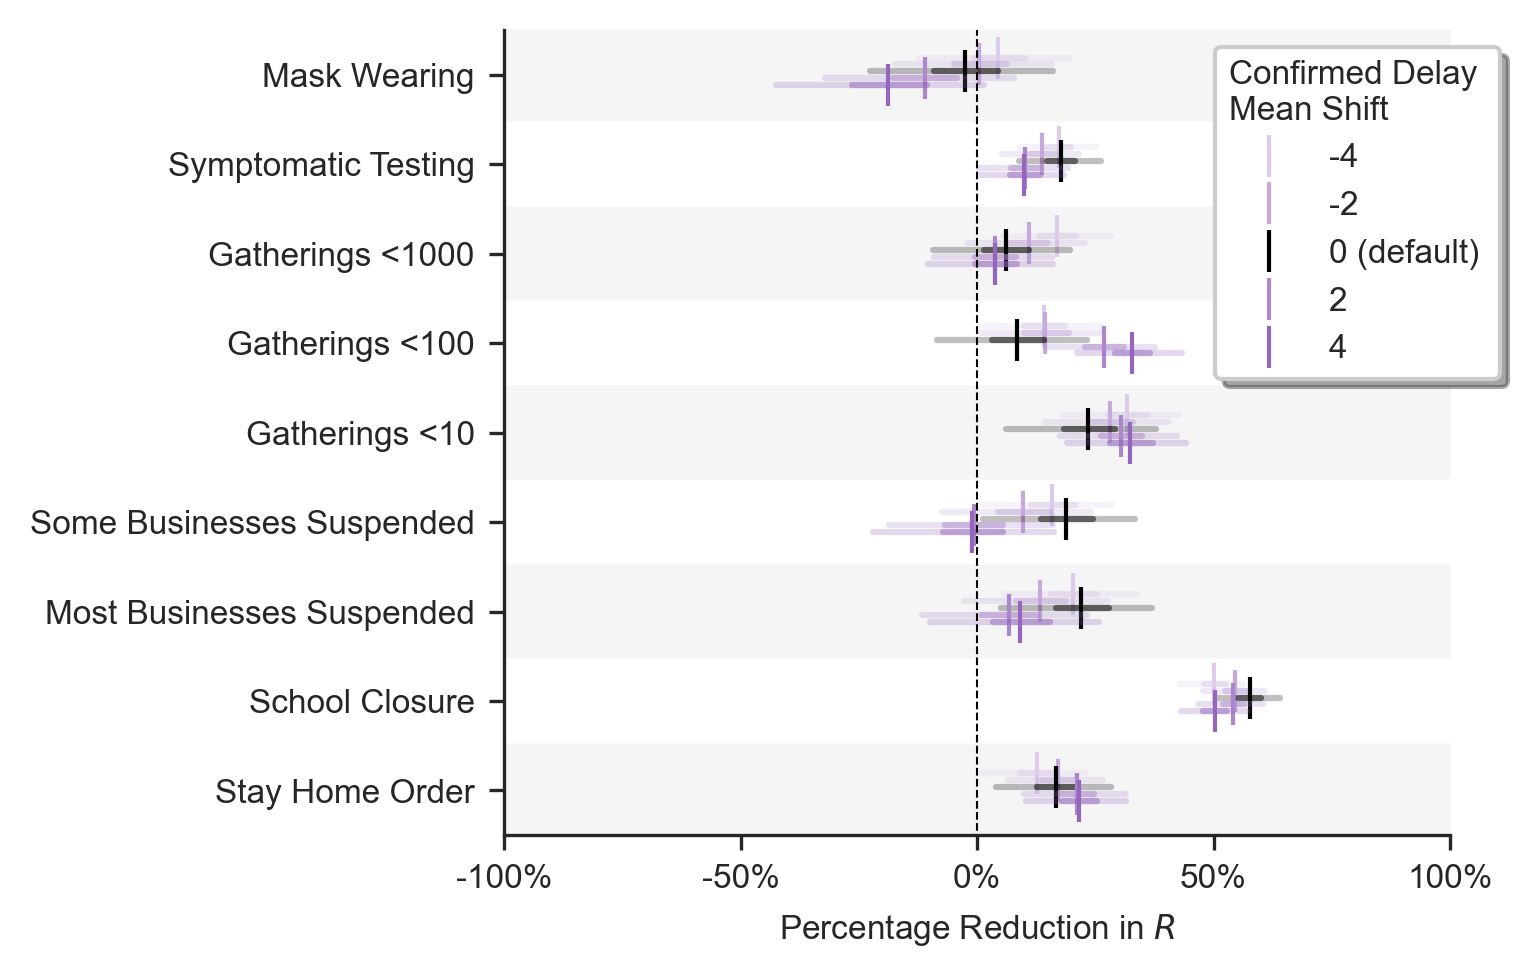

In [38]:
colors= sns.light_palette("tab:purple",n_colors=5)
colors.reverse()
colors.insert(index_default,[0,0,0])
colors = colors[0:5]
colors.reverse()

filenames = [f'out_final/delay_mean_confirmed_combined_{i}.txt' for i in range(len(mean_shift))]
filenames.insert(index_default,'out_final/default_combined.txt')
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               colors=colors,
                               y_offset=y_offset, 
                               legend_title='Confirmed Delay \nMean Shift',
                               bbox_to_anchor=(1.07,1),
                               figsize=(5.2,3.3))
plt.savefig('out_final/delay_mean_sensitivity_confirmed_combined.pdf')

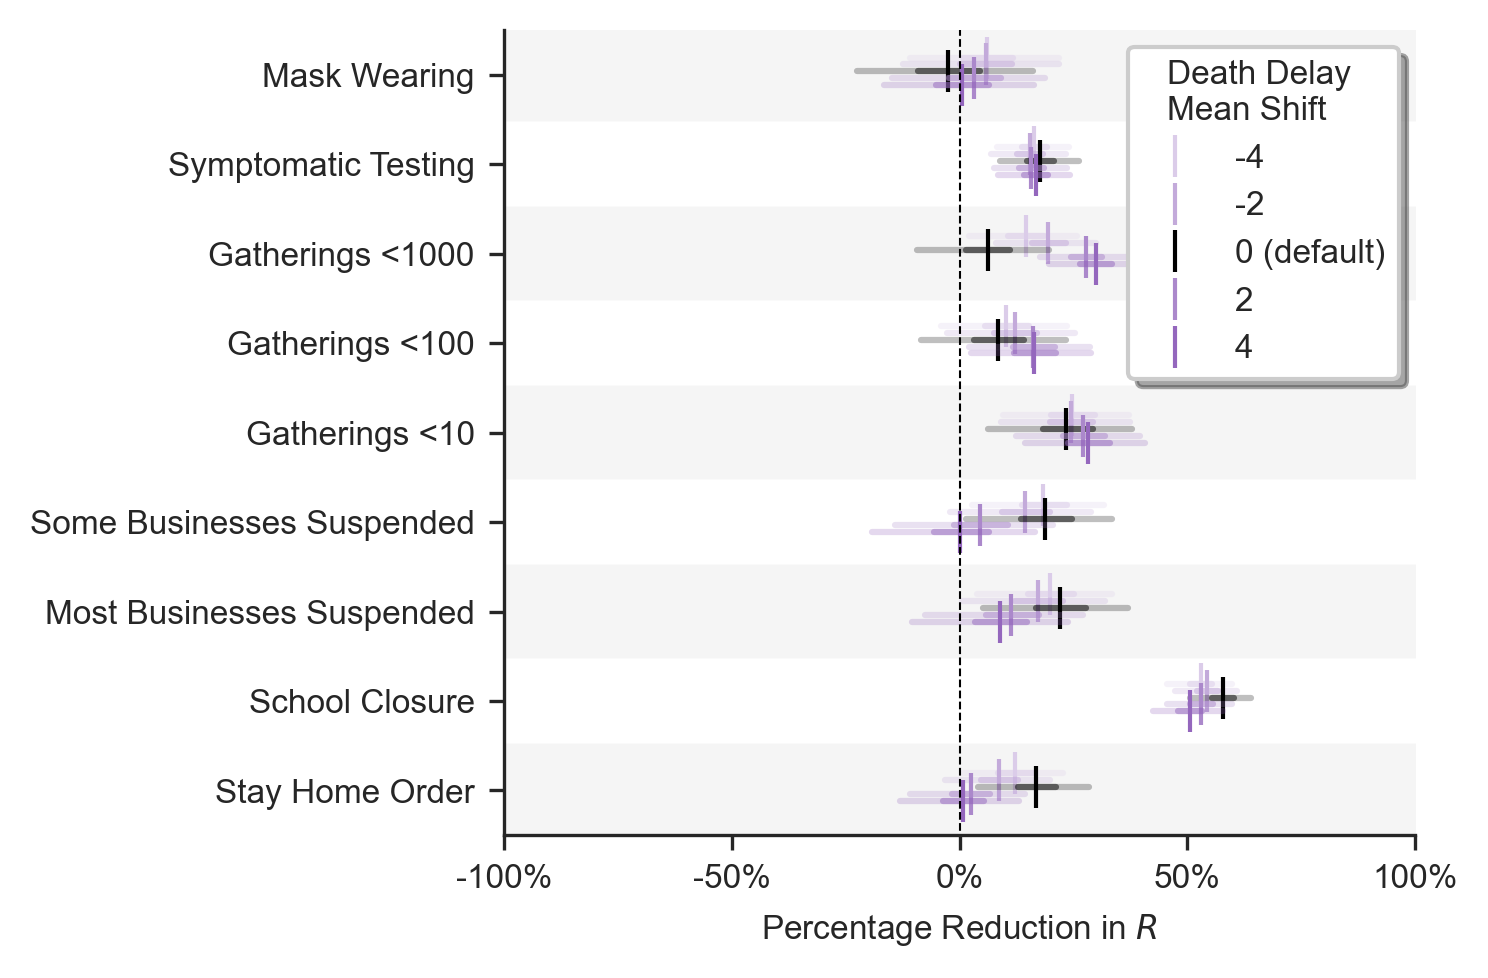

In [39]:
colors= sns.light_palette("tab:purple",n_colors=5)
colors.reverse()
colors.insert(index_default,[0,0,0])
colors = colors[0:5]
colors.reverse()

filenames = [f'out_final/delay_mean_death_combined_{i}.txt' for i in range(len(mean_shift))]
filenames.insert(index_default,'out_final/default_combined.txt')
spl.plot_cm_effect_sensitivity(filenames, cm_labels, legend_labels, 
                               colors=colors,
                               y_offset=y_offset,
                               legend_title='Death Delay \nMean Shift')
plt.savefig('out_final/delay_mean_sensitivity_death_combined.pdf')